# Resnet

In [1]:
import os
import glob
import time
import copy

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torchvision.models import resnet18, resnet50

from torchinfo import summary

* config 寫一下

In [2]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

## 理論介紹 & 自己寫

* 這邊介紹 resnet18, 然後自己寫一遍。之後實作時，都會改 resnet50, 但概念大同小異，只是疊更多層. 
* resnet18 的網路架構如下：

![](imgs/resnet18-90.svg)

* 從這張架構圖，可以得知：  
  * img 剛進來時，先經過 7x7 conv -> batch norm -> 3x3 max pooling，得到 feature map. 
  * `2x` 下面，看起來是一個 block，我先稱它為 `simple resnet block`.  
  * `3x` 下面，看起來是2個 block 串再一起，前面是多出一個 1x1 conv，我稱它為 `1x1 conv resnet block`, 後面就是剛剛看過的 `simple resnet block`。所以這邊是 3 個 (1x1 conv resnet block + simple resnet block) 的結構  
  * 最後用 global average pooling，得到這張圖的 embedding (512維而已，好清爽). 
  * 然後接個 fully connected layer, output 到 ImageNet 要預測的 1000 個類別
* 現在來細看一下 `2x`, `3x` 下的兩種 resnet block。如下圖：

![](imgs/resnet-block.svg)

* 右圖為啥要多一個 1x1 conv 呢？ 這是 shape 的考量：
  * 左圖 (simple resnet block)：
    * 一路的 conv, 都是通道數不變，高寬也不變(same padding)。
    * 所以 input x 是 (b, c, h, w), 經過一系列的 conv 後，還是 (b, c, h, w)，就可以和原本的 input x 直接相加  
  * 右圖 (1x1 conv resnet block)：
    * 一路的 conv, 會刻意將通道數翻倍，高寬減半(stride = 2)。
    * 所以 input x 是 (b, c, h, w), 經過一系列的 conv 後，變成 (b, 2c, h/2, w/2)，那就和原本的 x 的 shape不同。  
    * 所以把 input 做 1x1 conv (input_channel = c, output_channel = 2c, kernel_size = 1, stride = 2, padding = 0), 就可以把 input x 也變成通道數翻倍, 高寬減半，就可以相加了

* 這樣對 resnet 應該頗瞭解了。先來偷看一下 pytorch 的 pretrained resnet18, 等等就要自己造一個出來

In [3]:
resnet = resnet18(weights="IMAGENET1K_V1")
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

* nice，跟剛剛介紹的都一樣，唯一不樣的，是 `1x1 conv resnet block` 的部分，他除了做 1x1 conv 外，又多做了 batch normalization。但這無傷大雅。  
* 另外，為啥他要把它命名為 downsample? 因為他用 1x1 conv 把原本的 feature map 高寬減半(stride = 2, padding = 0)，所以是在做高寬的 down sample。  
* 現在應該信心滿滿了～ 來自己寫一個吧！

### resnet block

In [4]:
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, output_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(output_channels, output_channels,
                               kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_channels)
        if use_1x1conv:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channels, output_channels,kernel_size=1, stride=strides),
                nn.BatchNorm2d(output_channels)
            )
        else:
            self.downsample = None
        
    def forward(self, X):
        # 內層
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = self.relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2(Y)
        
        # 殘差連接層
        if self.downsample:
            X = self.downsample(X)
        Y += X
        
        # output
        Y = self.relu(Y)
        return Y

In [5]:
# simple resnet block
blk = Residual(input_channels = 64, output_channels = 64, use_1x1conv = False)
blk

Residual(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [6]:
# 1x1 conv resnet block
blk = Residual(input_channels = 64, output_channels = 128, use_1x1conv = True, strides = 2)
blk

Residual(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

### resnet network

* 再看一次圖：

![](imgs/resnet18-90.svg)

* 我想這樣組織我的 code:  
  * 前面這三層，我叫 b1 (block1). 
  * 再來的 `2x`，我叫 b2, 就用 sequential 接2次剛剛寫好的 `Residual` class 就好  
  * 再來的 `3x`, 我想把 `conv resnet block`+`simple resnet block` 定義為 `compose_resnet_block`，然後分別用 b3, b4, b5 設定三組 block. 
  * 最後就接 global average pooling 和 fully connected layer 就搞定了

In [7]:
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3)),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

b2 = nn.Sequential(
    Residual(input_channels = 64, output_channels = 64, use_1x1conv = False),
    Residual(input_channels = 64, output_channels = 64, use_1x1conv = False)
)

def compose_resnet_block(input_channels, output_channels):
    out = nn.Sequential(
        Residual(
            input_channels = input_channels, 
            output_channels = output_channels, 
            use_1x1conv = True,
            strides = 2
        ),
        Residual(
            input_channels = output_channels, 
            output_channels = output_channels, 
            use_1x1conv = False,
            strides = 1
        )
    )
    return out

b3 = compose_resnet_block(input_channels = 64, output_channels = 128)
b4 = compose_resnet_block(input_channels = 128, output_channels = 256)
b5 = compose_resnet_block(input_channels = 256, output_channels = 512)

# 組起來吧
my_resnet = nn.Sequential(
    b1, 
    b2, 
    b3, b4, b5,
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(), 
    nn.Linear(512, 1000)
)

In [8]:
my_resnet

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1

* 讚拉！ 跑一次看看：

In [10]:
input_img = torch.rand(10, 3, 224, 224)
out = my_resnet(input_img)
out.shape

torch.Size([10, 1000])

## Imagenet utils

In [11]:
# 1000 類的名稱
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip().split(',')[0] for s in f.readlines()]

In [12]:
# 看前10類
categories[:10]

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich']

In [13]:
# 影像餵入 model 前的前處理
def imagenet_preprocess(pil_obj, normalize = False):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    if normalize:
        transform = transforms.Compose([
            transform,
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])
        ])
        
    input_tensor = transform(pil_obj)
    return input_tensor

## import pretrained model & explore structure

* 主角，resnet50，這樣 import

In [14]:
from torchvision.models import resnet50

In [37]:
# model = resnet50(pretrained=True) # pytorch 舊版的寫法
model = resnet50(weights="IMAGENET1K_V1") # pytorch 新版的寫法

* 看一下 resnet50 的 structure

In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

* 可以看到和剛剛自己寫的大同小異。  
* 要做 feature extraction 的話，看來就是取到 `avgpool` 這個 block，再把他 flatten 成一維向量。  
* 要做 transfer learning 的話，就把最後一層的 linear，用新的 linear 來取代掉. 
* 先來看看幾種探索 structure 時常用的招

### 看個 layer 的 shape

In [17]:
summary(model, (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

* 可以看到
  * 一開始的輸入是 (3,224,224)
  * 最終，提取完的 feature map，就是 (2048, 7, 7)
  * AdaptiveAvgPool2d(1,1)就是 global average pooling, 做完後就是 2048 維的 embedding (這要背一下)
  * 再來進到分類的部分就是個 fully connected layer而已。從 2048 到目標的 1000 類

### 看 layer 的細節

In [20]:
model.named_children()

<generator object Module.named_children at 0x7fa27a47a7b0>

In [21]:
for n, c in model.named_children():
    print(n)
    print(c)
    print("-------------")

conv1
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
-------------
bn1
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
-------------
relu
ReLU(inplace=True)
-------------
maxpool
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
-------------
layer1
Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

### 取其中一個 children 出來

* 就直接抓就好

In [23]:
# 抓某個 layer
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

### 查某一個 layer 的屬性

* 例如最常見的，我想查最後一個 layer 的 input dim, 和 output dim，那就：

In [26]:
model.fc.in_features

2048

In [27]:
model.fc.out_features

1000

### 替換某一個 layer

* 例如，我想替換掉最後一個 layer, 我現在想做的分類只有 2 類

In [28]:
in_feature = model.fc.in_features # 2048
out_class = 2
model.fc = nn.Linear(in_feature, out_class)

# 看一下結果
model.fc

Linear(in_features=2048, out_features=2, bias=True)

### 取前 k 個 children 組成新 model

* 我如果想做 feature extraction, 那我想取 resnet 從最前面直到 `avgpool` 的 block
* 那我可以這樣做：

In [38]:
resnet_feature_extractor = nn.Sequential()
for name, block in model.named_children():
    resnet_feature_extractor.add_module(name, block)
    if name == "avgpool":
        break

In [39]:
resnet_feature_extractor

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

## resnet 直接用來預測

### input image

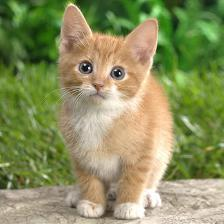

In [31]:
filename = 'images_test/cat.jpg'
input_image = Image.open(filename)
input_image

In [32]:
input_tensor = imagenet_preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # 增加一維(筆數)

In [33]:
print(input_tensor.shape)
print(input_tensor.dtype)
print(input_tensor.min())
print(input_tensor.max())

torch.Size([3, 224, 224])
torch.float32
tensor(0.)
tensor(1.)


### model

In [34]:
model = resnet50(weights="IMAGENET1K_V1")

### predict

In [35]:
model.eval()
with torch.no_grad():
    model = model.to(device)
    input_batch = input_batch.to(device)
    
    output = model(input_batch)

# 轉成機率
probabilities = torch.nn.functional.softmax(output[0], dim=0)
max_item = torch.argmax(probabilities).item()
print(f'{max_item} {categories[max_item]}: {torch.max(probabilities).item()}')

285 Egyptian cat: 0.3680180609226227


## 用來擷取特徵並做相似度搜尋

### model

In [40]:
model = resnet50(weights="IMAGENET1K_V1")

resnet_feature_extractor = nn.Sequential()
for name, block in model.named_children():
    resnet_feature_extractor.add_module(name, block)
    if name == "avgpool":
        break

resnet_feature_extractor.add_module("flatten", nn.Flatten())
resnet_feature_extractor

Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

* 最終，input一張圖，output 出 2048 維的向量

### images

In [42]:
import glob
abs_path_list = glob.glob("images_test/*")
filename_list = [i.split("/")[-1].replace(".jpg", "") for i in abs_path_list]

In [43]:
X = torch.tensor([])
for abs_path, filename in zip(abs_path_list, filename_list):
    input_image = Image.open(abs_path)
    input_tensor = imagenet_preprocess(input_image, True)
    input_batch = input_tensor.unsqueeze(0) # 增加一維(筆數)
    if len(X.shape) == 1:
        # print(input_batch.shape)
        X = input_batch
    else:
        # print(input_batch.shape)
        X = torch.cat((X, input_batch), dim=0)

In [44]:
X.shape

torch.Size([22, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


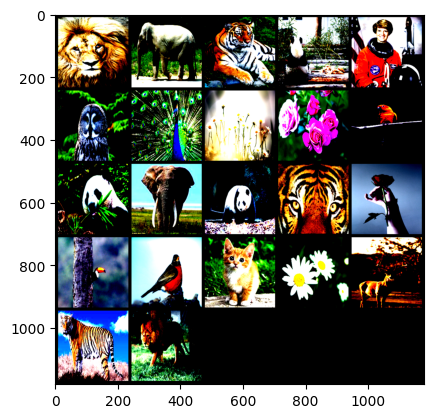

In [45]:
aa = make_grid(X, nrow = 5, padding = 10)
plt.imshow(aa.permute(1, 2, 0));

In [46]:
print(filename_list)

['lion2', 'elephant', 'tiger1', 'panda2', 'astronaut', 'owl', 'peacock', 'daisy2', 'rose.png', 'bird2', 'panda1', 'elephant2', 'panda3', 'tiger3', 'rose2', 'toucan', 'bird', 'cat', 'daisy1', 'deer', 'tiger2', 'lion1']


### feature extraction

In [48]:
model.eval()
with torch.no_grad():
    X = X.to(device)
    resnet_feature_extractor = resnet_feature_extractor.to(device)
    features = resnet_feature_extractor(X)
features.shape

torch.Size([22, 2048])

### 相似度

* 假設我今天的 query image 是 `tiger2.jpg`, 位於檔名list的倒數第二個 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


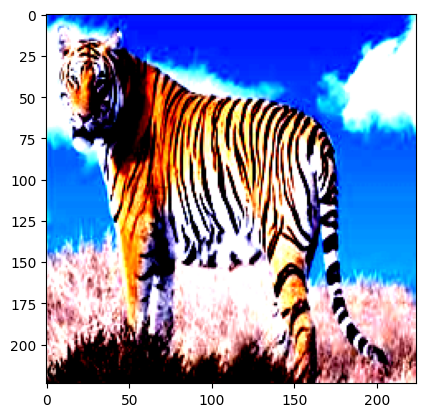

In [49]:
index = -2
plt.imshow(X[index].permute(1,2,0).cpu());

* 我想找找看，剛剛這 22 張圖中，哪個跟這張最像

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

features = features.cpu()

# Tiger2.jpg 的 embedding
tiger2_features = features[index:index+1] # shape = (1, 25088)

# 排除 Tiger2.jpg 的其他圖檔特徵向量
other_features = np.concatenate((features[:index], features[index+1:])) # shape = (21, 25088)

# 使用 cosine_similarity 計算 Cosine 函數
similar_list = cosine_similarity(tiger2_features, other_features, dense_output=False)

# 顯示相似度，由大排到小
print(np.sort(similar_list[0])[::-1])

[0.86341155 0.81118935 0.70302135 0.6954032  0.6351156  0.6197033
 0.6155931  0.61443794 0.6122488  0.60893935 0.58921397 0.5829755
 0.574617   0.5704397  0.53148544 0.5203887  0.4704514  0.4290331
 0.4275659  0.4199425  0.405274  ]


In [51]:
# 依相似度，由大排到小，顯示檔名
image_files2 = np.delete(filename_list, index)
image_files2[np.argsort(similar_list[0])[::-1]]

array(['tiger1', 'tiger3', 'cat', 'lion1', 'elephant2', 'panda1', 'owl',
       'astronaut', 'lion2', 'deer', 'elephant', 'panda3', 'bird',
       'panda2', 'daisy2', 'bird2', 'rose2', 'daisy1', 'toucan',
       'peacock', 'rose.png'], dtype='<U9')

* 果然和他最像的，是 tiger1, 再來是 tiger3。 not bad!

## transfer learning

### model 改最後一層就好

In [3]:
target_classes = 2
model = resnet50(weights="IMAGENET1K_V1")
# model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, target_classes)

### 決定要不要 freeze 之前的參數不 train

* 剛剛改寫了最後一層的 fully connected layer，所以這個 layer 的參數當然是 trainable. 
* 預設狀況下，前面 feature extraction 的所有層的參數，也都是 trainable. 
* 但如果想把前面都 freeze 住，可以這樣做：
```python
# freeze 住所有參數
for param in model.parameters():
    param.requires_grad = False

# 最後一層打開
for param in model.fc.parameters():
    param.requires_grad = True
```

### 決定 learning rate 要不要分開訂

* 做 transfer learning 時，前面的參數其實都已經訓練得很好了，需要的 learning rate 很小. 
* 相反的，最後一層的 classifier，是從隨機起始值開始，需要的 learning rate 比較大. 
* 所以比較好的作法，是給兩邊不同的 learning rate 
* (當然，比較簡單的作法，是直接給統一的，很小的 learning rate, 讓他在最後的 classifier 慢慢更新就好)

In [23]:
# 重寫 model
# feature extraction part: pretrained model
model = resnet50(weights="IMAGENET1K_V1")

resnet_feature_extractor = nn.Sequential()
for name, block in model.named_children():
    resnet_feature_extractor.add_module(name, block)
    if name == "avgpool":
        break

# classifier: new
num_ftrs = model.fc.in_features
target_classes = 2
classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(num_ftrs, target_classes)
)

# 合併
model = nn.Sequential()
model.add_module("base", resnet_feature_extractor)
model.add_module("classifier", classifier)

model

Sequential(
  (base): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

* 那我現在就可以指定兩個 part 的參數了： 
  * `model.base.parameters()` 
  * `model.classifier.parameters()`

In [24]:
optimizer = optim.SGD([
                {'params': model.base.parameters()},
                {'params': model.classifier.parameters(), 'lr': 1e-4}
            ], lr=1e-3, momentum=0.9)

### 其他就都和一般 training 一樣了

* 來做一個官網的資料集

#### 載入資料集

In [3]:
# 訓練資料進行資料增補，驗證資料不需要
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 資料增補
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 使用 ImageFolder 可方便轉換為 dataset
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# 取得資料筆數
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# 取得類別
class_names = image_datasets['train'].classes

#### 顯示 training data

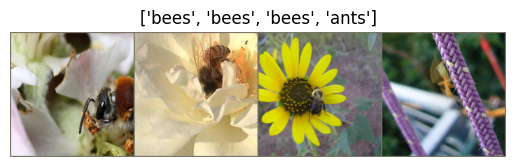

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 取得一批資料
inputs, classes = next(iter(dataloaders['train']))

# 顯示一批資料
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

#### training/validation 用的函數

In [25]:
# 定義 model
# 前面已做完, 叫 model
model = model.to(device)


# 定義 optimizer
# 前面已做完, 叫 optimizer, 且有不同 learning rate
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 定義損失函數
criterion = nn.CrossEntropyLoss()

# 每7個執行週期，學習率降 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
# 同時含訓練/評估
def train_model(model, 
                criterion, 
                optimizer, 
                scheduler, 
                num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 逐批訓練或驗證
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # 訓練時需要梯度下降
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練時需要 backward + optimize
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 統計損失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 如果是評估階段，且準確率創新高即存入 best_model_wts
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 載入最佳模型
    model.load_state_dict(best_model_wts)
    return model

#### 開 train

In [27]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5472 Acc: 0.6721
val Loss: 0.2837 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.3789 Acc: 0.8074
val Loss: 0.1794 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.3411 Acc: 0.8443
val Loss: 0.2274 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.2491 Acc: 0.9139
val Loss: 0.2081 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3035 Acc: 0.8770
val Loss: 0.1857 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.2478 Acc: 0.9180
val Loss: 0.1515 Acc: 0.9477

Epoch 6/24
----------
train Loss: 0.2780 Acc: 0.8770
val Loss: 0.2146 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.2716 Acc: 0.8852
val Loss: 0.4029 Acc: 0.8235

Epoch 8/24
----------
train Loss: 0.2503 Acc: 0.9057
val Loss: 0.2389 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2715 Acc: 0.8893
val Loss: 0.1905 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3650 Acc: 0.8361
val Loss: 0.2173 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3001 Acc: 0.8607
val Loss: 0.1743 Acc: 0.9216

Ep